<a href="https://colab.research.google.com/github/haokeliu/colaboratory/blob/master/DeepLearn_Notes/%E5%A4%9A%E5%B1%82%E6%84%9F%E7%9F%A5_Multilayer_Perceptron_(MLP).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##**数据Data**

我们将为分类任务生产一些非线性数据

In [1]:
# Load PyTorch library
!pip3 install torch torchvision

In [0]:
from argparse import Namespace
import matplotlib.pylab as plt
import numpy as np
import random
import torch

Argparse的作用就是为py文件封装好可以选择的参数，使他们更加灵活，丰富。

In [0]:
# Arguments
args = Namespace(
    seed = 1234,
    num_samples_per_class = 500,
    dimensions = 2, # n.	维
    num_classes = 3,
    train_size = 0.75,
    test_size = 0.25,
    num_hidden_units = 100,
    learning_rate = 1e-0,
    regularization = 1e-3,
    num_epochs = 200,
)
# Set seed for reproducability
np.random.seed(args.seed)

In [0]:
# Generate non-linear data
def generate_data(num_samples_per_class, dimensions, num_classes):
    # Make synthetic spiral data
    X_original = np.zeros((num_samples_per_class*num_classes, dimensions))
    y = np.zeros(num_samples_per_class*num_classes, dtype='uint8')
    for j in range(num_classes):
        ix = range(num_samples_per_class*j,num_samples_per_class*(j+1))
        r = np.linspace(0.0,1,num_samples_per_class) # radius
        t = np.linspace(j*4,(j+1)*4,num_samples_per_class) + \
        np.random.randn(num_samples_per_class)*0.2 # theta
        X_original[ix] = np.c_[r*np.sin(t), r*np.cos(t)] # 随机点 横坐标sin x 纵坐标 cos x
        y[ix] = j # 类别标签 j

    # Stack
    X = np.hstack([X_original])
#     两个拼接数组的方法：
#     np.vstack():在竖直方向上堆叠
#     np.hstack():在水平方向上平铺
    return X, y

In [5]:
# Generate X & y
X, y = generate_data(num_samples_per_class=args.num_samples_per_class, 
                     dimensions=args.dimensions, num_classes=args.num_classes)
print ("X: {0}".format(np.shape(X)))
print ("y: {0}".format(np.shape(y)))

X: (1500, 2)
y: (1500,)


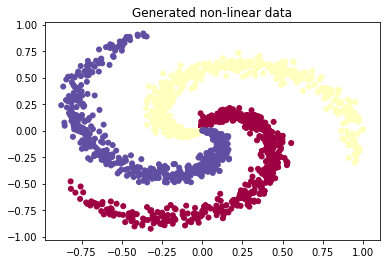

In [6]:
#scatter散点图
plt.title("Generated non-linear data")
plt.scatter(X[:, 0], X[:, 1], c=y, s=25, cmap=plt.cm.Spectral)
plt.show()

In [0]:
# Convert to PyTorch tensors
X = torch.from_numpy(X).float()
y = torch.from_numpy(y).long()

In [8]:
# Shuffle data
shuffle_indicies = torch.LongTensor(random.sample(range(0, len(X)), len(X)))
X = X[shuffle_indicies]
y = y[shuffle_indicies]

# Split datasets
test_start_idx = int(len(X) * args.train_size)
X_train = X[:test_start_idx] 
y_train = y[:test_start_idx] 
X_test = X[test_start_idx:] 
y_test = y[test_start_idx:]
print("We have %i train samples and %i test samples." % (len(X_train), len(X_test)))

We have 1125 train samples and 375 test samples.


## **线性模型 Linear model**
在使用神经网络之前，我们先用 PyTorch 的线性模型（逻辑回归）试一下。我们想看看为什么线性模型不能满足数据要求。

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset,DataLoader
from tqdm import tqdm_notebook

In [0]:
# Linear model
class LogisticClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(LogisticClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x_in, apply_softmax=False):
        a_1 = self.fc1(x_in)
        y_pred = self.fc2(a_1)

        if apply_softmax:
            y_pred = F.softmax(y_pred, dim=1)

        return y_pred

In [11]:
# Initialize model
model = LogisticClassifier(input_dim=args.dimensions, 
                           hidden_dim=args.num_hidden_units, 
                           output_dim=args.num_classes)
print (model.named_modules)

<bound method Module.named_modules of LogisticClassifier(
  (fc1): Linear(in_features=2, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=3, bias=True)
)>


In [0]:
# Optimization
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr = args.learning_rate)
## Adam optimizer (usually better than SGD)

In [0]:
# Accuracy
def get_accuracy(y_pred, y_target):
    n_correct = torch.eq(y_pred, y_target).sum().item()
    accuracy = n_correct / len(y_pred) * 100
    return accuracy

In [14]:
# Training
for t in range(args.num_epochs):
    # Forward pass
    y_pred = model(X_train)
    
    # Accuracy
    _, predictions = y_pred.max(dim=1)
    accuracy = get_accuracy(y_pred=predictions.long(), y_target=y_train)

    # Loss
    loss = loss_fn(y_pred, y_train)
    
    # Verbose
    if t%20==0: 
        print ("epoch: {0:02d} | loss: {1:.4f} | acc: {2:.1f}%".format(
            t, loss, accuracy))

    # Zero all gradients
    optimizer.zero_grad()

    # Backward pass
    loss.backward()

    # Update weights
    optimizer.step()

epoch: 00 | loss: 1.1433 | acc: 20.0%
epoch: 20 | loss: 16.8911 | acc: 54.8%
epoch: 40 | loss: 6.9756 | acc: 50.9%
epoch: 60 | loss: 2.1974 | acc: 57.0%
epoch: 80 | loss: 0.9065 | acc: 60.4%
epoch: 100 | loss: 0.7516 | acc: 55.9%
epoch: 120 | loss: 0.7312 | acc: 52.9%
epoch: 140 | loss: 0.7302 | acc: 53.2%
epoch: 160 | loss: 0.7300 | acc: 52.7%
epoch: 180 | loss: 0.7299 | acc: 52.7%


In [0]:
# Predictions
_, pred_train = model(X_train, apply_softmax=True).max(dim=1)
_, pred_test = model(X_test, apply_softmax=True).max(dim=1)

In [16]:
#Train and test accuracies
train_acc = get_accuracy(y_pred =pred_train,y_target=y_train)
test_acc = get_accuracy(y_pred = pred_test,y_target=y_test)
print ("train acc: {0:.1f}%, test acc: {1:.1f}%".format(train_acc, test_acc))

train acc: 52.7%, test acc: 52.8%


In [0]:
# Visualization
def plot_multiclass_decision_boundary(model, X, y):
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))
    cmap = plt.cm.Spectral
    
    X_test = torch.from_numpy(np.c_[xx.ravel(), yy.ravel()]).float()
    y_pred = model(X_test, apply_softmax=True)
    _, y_pred = y_pred.max(dim=1)
    y_pred = y_pred.reshape(xx.shape)
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.Spectral, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

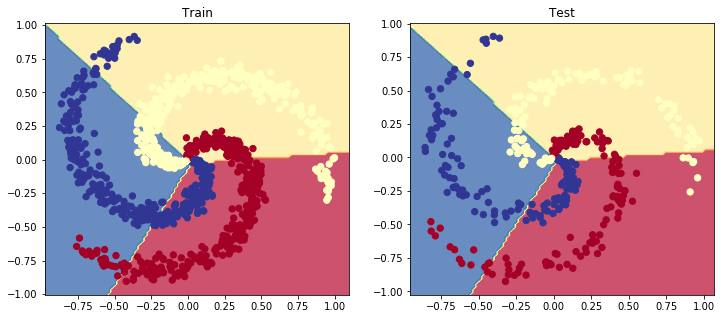

In [18]:
# Visualize the decision boundary
plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_multiclass_decision_boundary(model=model, X=X_train, y=y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_multiclass_decision_boundary(model=model, X=X_test, y=y_test)
plt.show()

In [0]:
import itertools
from sklearn.metrics import classification_report, confusion_matrix

In [0]:
# Plot confusion matrix
def plot_confusion_matrix(cm, classes):
    cmap=plt.cm.Blues
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title("Confusion Matrix")
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.grid(False)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'), horizontalalignment="center", 
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

              precision    recall  f1-score   support

           0       0.50      0.48      0.49       130
           1       0.53      0.66      0.59       115
           2       0.56      0.45      0.50       130

    accuracy                           0.53       375
   macro avg       0.53      0.53      0.53       375
weighted avg       0.53      0.53      0.52       375



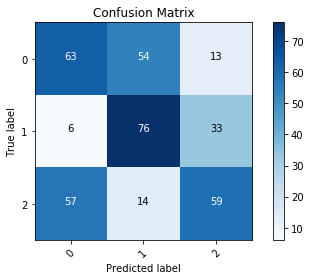

In [21]:
# Confusion matrix
cm = confusion_matrix(y_test, pred_test)
plot_confusion_matrix(cm=cm, classes=[0, 1, 2])
print (classification_report(y_test, pred_test))

##**非线性模型 Non-linear model**


> 现在，我们按一下 MLP 如何工作的。注意：和之前唯一的区别是增加了非线性的激活函数（我们使用 ReLU $max(0, z)）。



In [0]:
# Multilayer Perceptron 
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x_in, apply_softmax=False):
        a_1 = F.relu(self.fc1(x_in)) # activaton function added!
        y_pred = self.fc2(a_1)

        if apply_softmax:
            y_pred = F.softmax(y_pred, dim=1)

        return y_pred

In [23]:
model = MLP(input_dim = args.dimensions,
            hidden_dim = args.num_hidden_units,
            output_dim = args.num_classes
           )
print(model.named_modules)

<bound method Module.named_modules of MLP(
  (fc1): Linear(in_features=2, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=3, bias=True)
)>


In [0]:
#Optimization
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr = args.learning_rate)

In [25]:
# Training
for t in range(args.num_epochs):
    # Forward pass
    y_pred = model(X_train)
    
    # Accuracy
    _, predictions = y_pred.max(dim=1)
    accuracy = get_accuracy(y_pred=predictions.long(), y_target=y_train)

    # Loss
    loss = loss_fn(y_pred, y_train)
    
    # Verbose
    if t%20==0: 
        print ("epoch: {0:02d} | loss: {1:.4f} | acc: {2:.1f}%".format(
            t, loss, accuracy))

    # Zero all gradients
    optimizer.zero_grad()

    # Backward pass
    loss.backward()

    # Update weights
    optimizer.step()

epoch: 00 | loss: 1.0793 | acc: 51.2%
epoch: 20 | loss: 0.5884 | acc: 75.9%
epoch: 40 | loss: 0.1070 | acc: 97.4%
epoch: 60 | loss: 0.0516 | acc: 99.1%
epoch: 80 | loss: 0.0357 | acc: 99.4%
epoch: 100 | loss: 0.0297 | acc: 99.6%
epoch: 120 | loss: 0.0261 | acc: 99.6%
epoch: 140 | loss: 0.0234 | acc: 99.7%
epoch: 160 | loss: 0.0212 | acc: 99.7%
epoch: 180 | loss: 0.0195 | acc: 99.7%


In [0]:
# Predictions
_, pred_train = model(X_train, apply_softmax=True).max(dim=1)
_, pred_test = model(X_test, apply_softmax=True).max(dim=1)

In [27]:
# Train and test accuracies
train_acc = get_accuracy(y_pred=pred_train, y_target=y_train)
test_acc = get_accuracy(y_pred=pred_test, y_target=y_test)
print ("train acc: {0:.1f}%, test acc: {1:.1f}%".format(train_acc, test_acc))

train acc: 99.8%, test acc: 98.4%


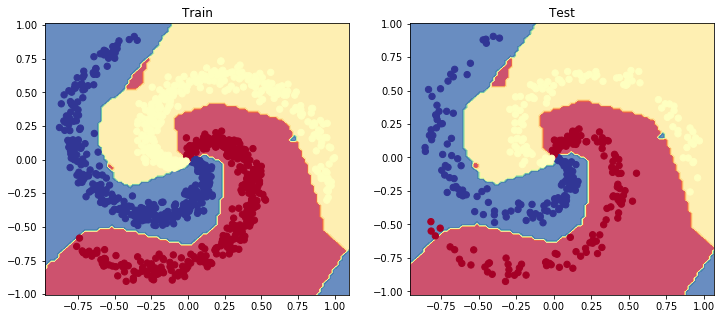

In [28]:
# Visualize the decision boundary
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.title("Train")
plot_multiclass_decision_boundary(model= model,X=X_train,y=y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_multiclass_decision_boundary(model = model,X=X_test,y=y_test)
plt.show()

              precision    recall  f1-score   support

           0       1.00      0.95      0.98       130
           1       1.00      1.00      1.00       115
           2       0.96      1.00      0.98       130

    accuracy                           0.98       375
   macro avg       0.99      0.98      0.98       375
weighted avg       0.98      0.98      0.98       375



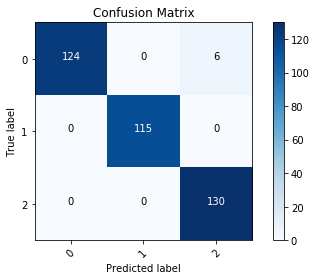

In [29]:
# Confusion matrix
cm = confusion_matrix(y_test, pred_test)
plot_confusion_matrix(cm=cm, classes=[0, 1, 2])
print (classification_report(y_test, pred_test))

In [30]:
# Install TensorboardX
!pip3 install tensorboardX

     |████████████████████████████████| 245kB 2.0MB/s 


In [0]:
# Run tensorboard on port 6006
LOG_DIR = './log'
run_num = 0
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)

In [32]:
# Install localtunnel
!npm install -g localtunnel

/tools/node/bin/lt -> /tools/node/lib/node_modules/localtunnel/bin/client
+ localtunnel@1.9.1
added 55 packages from 34 contributors in 2.96s


In [0]:
# Tunnel port 6006 for tensorboard
get_ipython().system_raw('lt --port 6006 >> tensorboard.txt 2>&1 &')

In [34]:
# Few things needed to get tensorboard working
from tensorboardX import SummaryWriter
import torchvision.utils as vutils
!pip install Pillow==4.0.0
!pip install PIL
!pip install image
from PIL import Image
def register_extension(id, extension): Image.EXTENSION[extension.lower()] = id.upper()
Image.register_extension = register_extension
def register_extensions(id, extensions): 
    for extension in extensions: register_extension(id, extension)
Image.register_extensions = register_extensions

     |████████████████████████████████| 5.6MB 1.9MB/s 
ERROR: torchvision 0.2.2.post3 has requirement pillow>=4.1.1, but you'll have pillow 4.0.0 which is incompatible.
ERROR: scikit-image 0.15.0 has requirement pillow>=4.3.0, but you'll have pillow 4.0.0 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: Pillow 4.3.0
    Uninstalling Pillow-4.3.0:
      Successfully uninstalled Pillow-4.3.0


  ERROR: Could not find a version that satisfies the requirement PIL (from versions: none)
ERROR: No matching distribution found for PIL
